# style

## setup

In [1]:
from collections import Counter, defaultdict
import math
import torch
import torch.nn.functional as F
import PIL
import copy
from tqdm.auto import tqdm
import numpy as np
import torchvision.models as models
import transformers
from transformers import AutoImageProcessor, ResNetForImageClassification
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tqdm = lambda x: x # disable tqdm progress bar for the demo

In [3]:
# load from torchvision pre-trained VGG19
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
# load things from huggingface
transformers.logging.set_verbosity_error() # suppress warnings
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50") # for imagenet labels
do_normalize = False # keep images human readable
# labels
id2label = resnet.config.id2label

## Helpers

In [4]:
# plot the image and optinal labels in a grid
def plot(*args, n_col=None, figsize=None, axis_off=True):
    '''Plot the images in a grid with optional labels'''
    # prepare the elements to plot as (image, label)
    elems = []
    for el in args:
        if isinstance(el, torch.Tensor):
            if el.dim() == 4: el = el[0] # if picture is a batch, take the first one
            assert el.dim() == 3, f"Wrong image shape {el.shape}"
            if el.shape[0] == 3: el = el.permute(1, 2, 0)
            if el.requires_grad: el = el.detach()
            elems.append([el])
        elif isinstance(el, str): elems[-1].append(el)
        else: raise ValueError(f"Wrong element ({type(el)}) {repr(el)}")
    elems = [(el[0], el[1] if len(el) == 2 else None) for el in elems]

    # plot the images
    n_col = n_col or len(elems)
    n_row = math.ceil(len(elems) / n_col)
    figsize = figsize or (n_col * 4, n_row * 4)
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([ax])
    for i, (img, label) in enumerate(elems):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if label: ax[*idx].set_title(label)
        ax[*idx].imshow(img)
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i,) if n_row == 1 or n_col == 1 else (i // n_col, i % n_col)
        if axis_off: ax[*idx].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# classify things
@torch.no_grad()
def classify(img, model):
    logits = model.to(device)(img.to(device))
    if not isinstance(logits, torch.Tensor): logits = logits.logits
    confidence = logits.softmax(dim=-1).max()
    label = id2label[logits.argmax(dim=-1).item()]
    return label, confidence

def all_classify(img):
    res = []
    models = [
        ('VGG19', vgg),
        ('ResNet', resnet)
    ]
    for name, model in models:
        label, confidence = classify(img, model)
        if len(label) > 20: label = label[:20] + '...'
        res.append(f'{name:6}: {label:23} ({confidence*100:.2f}%)')
    return '\n'.join(res)

def plotl(*args):
    '''expecting tuples of (image, label)'''
    av = []
    for img, label in args:
        av.append(img)
        av.append(f'{label}\n{all_classify(img)}')
    plot(*av)

In [6]:
# hook some activation layer
def hook(layer, k, mem=None):
    if mem is None: mem = {}
    def f(module, input, output):
        mem[k] = output
    layer.register_forward_hook(f)
    return mem

def hooked(model):
    m = copy.deepcopy(model).to(device)
    mem = {}
    for layer in range(37):
        mem = hook(m.features[layer], layer, mem=mem)
    return mem, m

In [7]:
def disable_tqdm(f):
    def wrapper(*args, **kwargs):
        try:
            original_tqdm = tqdm
            globals()['tqdm'] = lambda x: x
            result = f(*args, **kwargs)
        finally:
            globals()['tqdm'] = original_tqdm
        return result
    return wrapper

## style

### load images

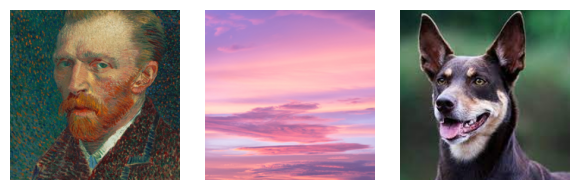

In [8]:
vangogh = processor(PIL.Image.open('imgs/vangogh.jpg'), return_tensors='pt', do_normalize=do_normalize)['pixel_values']
sky = processor(PIL.Image.open('imgs/sky.jpg'), return_tensors='pt', do_normalize=do_normalize)['pixel_values']
kelpie = processor(PIL.Image.open('imgs/kelpie1.jpg'), return_tensors='pt', do_normalize=do_normalize)['pixel_values']
plot(vangogh, sky, kelpie, figsize=(6, 2))

### hook VGG
hook all the activation layers from VGG so we can use them during gradient ascent for dreaming

In [9]:
vgg_mem, vgg_hooked = hooked(vgg)
# the VGG model on torchvision is much easier to look into than ResNet from huggingface
vgg_hooked.features[:10]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### heatmap

### image un-compression

### styling ?!

### ??? old deepdream code for copy paste

In [10]:
def shallowdream(start, layer=35, channel=None, m=vgg_hooked, mem=vgg_mem, learning_rate=0.01, epochs=30):
    start = copy.deepcopy(start.detach())
    # move to device
    dream = start.to(device).requires_grad_()
    m = m.to(device)

    for _ in tqdm(range(epochs)):
        m(dream)
        loss = mem[layer].norm() if channel is None else mem[layer][:, channel, :, :].norm()
        dream.grad = None
        loss.backward()
        dream.data = torch.clip((dream + dream.grad * learning_rate), 0., 1.).data # jumping through hoops to please pytorch
    return dream

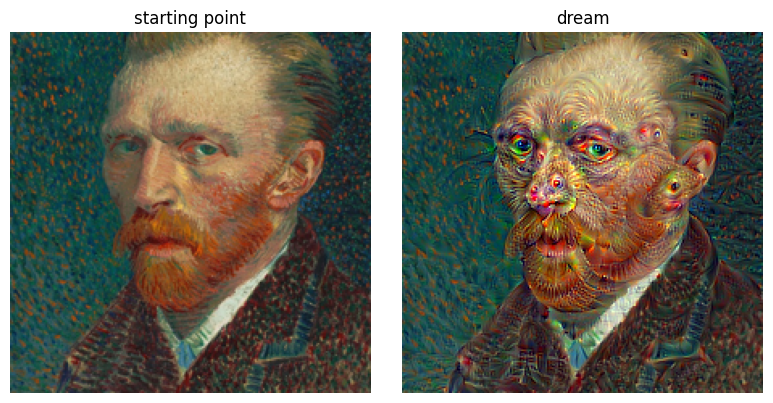

In [11]:
dream = shallowdream(vangogh, layer=28, learning_rate=0.02, epochs=20).to('cpu')
plot(vangogh, 'starting point',
     dream, 'dream')

### Identify channels

In [13]:
def save_activations(start, m=vgg_hooked, mem=vgg_mem):
    # move to device
    dream = start.to(device).requires_grad_()
    m = m.to(device)
    # run the model
    m(dream)
    # make a copy of the activations
    activations = {k: copy.deepcopy(output.detach()) for k, output in mem.items()}
    return activations

save_activations(kelpie)

{0: tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.2220, 0.4021, 0.3982,  ..., 0.7067, 0.7217, 1.2617],
           [0.0641, 0.3106, 0.3029,  ..., 0.3006, 0.3253, 1.2386],
           [0.0546, 0.3093, 0.3061,  ..., 0.2987, 0.3240, 1.2442],
           ...,
           [0.0000, 0.3105, 0.3063,  ..., 0.3552, 0.3459, 1.3950],
           [0.0000, 0.3191, 0.3145,  ..., 0.3196, 0.3089, 1.3630],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3674]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0